# NYC TLC data project


## Description
Author: Shuheng Mo       
Contact: shuheng_mo@outlook.com, shuheng_mo_mail@163.com      
Notifications: Running data processing sections might be time-consuming, for readers who focus on results and and conclusions please load processed(cleaned) data from folder `clean_data/` and start from section `Exploratory Data Analysis`.

## Business Understanding
In Newyork City, all taxi vehicles are managed by TLC (Taxi and Limousine Commission), here is a brief description about TLC:
```
The New York City Taxi and Limousine Commission (TLC), created in 1971, is the agency 
responsible for licensing and regulating New York City's Medallion (Yellow) taxi cabs, for-hire 
vehicles (community-based liveries, black cars and luxury limousines), commuter vans, and 
paratransit vehicles. The Commission's Board consists of nine members, eight of whom are 
unsalaried Commissioners. The salaried Chair/ Commissioner presides over regularly 
scheduled public commission meetings and is the head of the agency, which maintains a 
staff of approximately 600 TLC employees.
Over 200,000 TLC licensees complete approximately 1,000,000 trips each day. To operate for 
hire, drivers must first undergo a background check, have a safe driving record, and 
complete 24 hours of driver training. TLC-licensed vehicles are inspected for safety and 
emissions at TLC's Woodside Inspection Facility.
```
Now NYC TLC has released its Trip Record data to public for research and study purposes. There are three main taxi types in NYC:
* Yellow taxis are traditionally hailed by signaling to a driver who is on duty and seeking a 
passenger (street hail), but now they may also be hailed using an e-hail app like Curb or Arro. 
Yellow taxis are the only vehicles permitted to respond to a street hail from a passenger in all 
five boroughs.
* Green taxis, also known as boro taxis and street-hail liveries, were introduced in August of 
2013 to improve taxi service and availability in the boroughs. Green taxis may respond to 
street hails, but only in the areas indicated in green on the map (i.e. above W 110 St/E 96th St 
in Manhattan and in the boroughs).
* FHV data includes trip data from high-volume for-hire vehicle bases (bases for companies 
dispatching 10,000+ trip per day, meaning Uber, Lyft, Via, and Juno), community livery bases, 
luxury limousine bases, and black car bases.              

Uber as one of the biggest ride-hailing services providers, its trip records are collected in `High Volume For-Hire Vehicle Trip 
Records` as well. In this project, there are three business goals we want to achieve to improve Uber's ride-hailing service:
1. Exploratory data analysis, research data `fhvhv_tripdata_2021-01` and figure out underlying trip patterns in Jan,2021.
2. Based on `fhvhv_tripdata_2021-01` and weather data, build predict model to predict the peak footfall. 
3. Try explore Uber's user portrait and study the user's wishes when the price was increased.

## Data requirements
Because of the privacy policy, some user data has been encrypted or masked.

## Data collection

TLC provided the data and downloaded as `NYC TLC.zip`, the file structure of decompressed folder `NYC TLC`:
```
.
├── data_dictionary_trip_records_hvfhs.pdf
├── fhvhv_tripdata_2021-01.parquet
├── fhvhv_tripdata_2021-02.parquet
├── fhvhv_tripdata_2021-03.parquet
├── fhvhv_tripdata_2021-04.parquet
├── fhvhv_tripdata_2021-05.parquet
├── fhvhv_tripdata_2021-06.parquet
├── fhvhv_tripdata_2021-07.parquet
├── fhvhv_tripdata_2021-08.parquet
├── fhvhv_tripdata_2021-09.parquet
├── fhvhv_tripdata_2021-10.parquet
├── fhvhv_tripdata_2021-11.parquet
├── fhvhv_tripdata_2021-12.parquet
├── nyc 2021-01-01 to 2021-12-31.csv
├── taxi+_zone_lookup.csv
├── taxi_zones
│   ├── taxi_zones.dbf
│   ├── taxi_zones.prj
│   ├── taxi_zones.sbn
│   ├── taxi_zones.sbx
│   ├── taxi_zones.shp
│   ├── taxi_zones.shp.xml
│   └── taxi_zones.shx
├── taxi_zones.zip
└── working_parquet_format.pdf
```
which `nyc 2021-01-01 to 2021-12-31.csv` record the weather data of year 2021,`taxi+_zone_lookup.csv` stored the zone information of all taxi, data file end with `.parquet` will be processed with pyarrow.

## Data understanding
The data dictionary of Trip Record data please refer to official site https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page.         
or just read the summary in `data_dictionary_trip_records_hvfhs.pdf`. Datasets that will be used are explained:

Dataset 1: fhvhv_tripdata_2021-01.parquet, 11908468 rows, 24 columns
- Features: (see 'data_dictionary_trip_records_hvfhs.pdf')     
Multiple dataset end with `.parquet` could be used according to requirements.

Dataset 2: nyc 2021-01-01 to 2021-12-31.csv, 365 rows, 21 columns
- Features:
    - 'name':
    - 'address':
    - 'resolvedAddress':
    - 'datetime':
    - 'temp':
    - 'feelslike':
    - 'dew':
    - 'humidity':
    - 'precip':
    - 'precipprob':
    - 'preciptype':
    - 'snow':
    - 'snowdepth':
    - 'windgust':
    - 'windspeed':
    - 'winddir':
    - 'sealevelpressure':
    - 'cloudcover':
    - 'visibility':
    - 'uvindex':
    - 'severerisk':

Dataset 3: taxi+_zone_lookup.csv, 265 rows, 4 columns
- Features:
    - LocationID:
    - Borough:
    - Zone:
    - service_zone:

## Pre-requisites & Auxiliary Functions

In [1]:
# ! pip install -r requirements.txt
## imports
import itertools
import numpy as np
import pandas as pd
import geopandas as gpd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import folium
import xgboost as xgb
import plotly.express as px
from datetime import time
from PIL import Image
from time import perf_counter
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from folium.plugins import HeatMap, HeatMapWithTime

## migic functions
%matplotlib inline

# auxiliary functions
## data processing methods
def check_missing_val(data):
    print("Checking attributes that have missing values...")
    for col in data.columns:
        if data[col].isnull().sum() !=0:
            print("{} : {}".format(col,data[col].isnull().sum()))

def check_uniqueness(data):
    print("Checking uniqueness of each attributes ...")
    for col in data.columns:
        print("{} : {} -> {}".format(col,data[col].is_unique,len(data[col].unique())))
        
def get_quantile(data,col_name,q_val,inter):
    return np.percentile(data[col_name],q_val,method=inter)

def iqr_test(data,col_name,inter):
    qu = get_quantile(data,'quantity',75,inter)
    ql = get_quantile(data,'quantity',25,inter)
    diff = qu - ql
    U = qu + 1.5 * diff
    L = ql - 1.5 * diff
    return U,L

def remove_outliers(data,col_name,inter):
    """filter the outliers of the numerical data

    Args:
        data (_type_): _description_
        col_name (_type_): _description_
        inter (_type_): _description_

    Returns:
        _type_: _description_
    """
    U,L = iqr_test(data,col_name,inter)
    return data[data[col_name]>= L | data[col_name]<=U]
    
        
def get_kmeans_categories(centroid,centers):
    """Returns the correct class when centroid is given

    Args:
        centroid (float): centroid assigned to given order
        centers (float): all centroids given by KNN

    Returns:
        str: specified distance range
    """
    if centroid == centers[0]:
        return 'short_range'
    elif centroid == centers[1]:
        return 'mid_range'
    else:
        return 'long_range'
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix. 
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Data Wrangling

### Data Loading and pre-processing

In [115]:
fhvhv_tripdata_2021_01 = pq.read_table('NYC TLC/fhvhv_tripdata_2021-01.parquet')
fhvhv_tripdata_2021_01 = fhvhv_tripdata_2021_01.to_pandas()

In [116]:
fhvhv_tripdata_2021_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11908468 entries, 0 to 11908467
Data columns (total 24 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[ns]
 4   on_scene_datetime     datetime64[ns]
 5   pickup_datetime       datetime64[ns]
 6   dropoff_datetime      datetime64[ns]
 7   PULocationID          int64         
 8   DOLocationID          int64         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

In [117]:
# we see those flags are boolean values, can be represented as 0 and 1
fhvhv_tripdata_2021_01['shared_request_flag'] = fhvhv_tripdata_2021_01['shared_request_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['shared_match_flag'] = fhvhv_tripdata_2021_01['shared_match_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['access_a_ride_flag'] = fhvhv_tripdata_2021_01['access_a_ride_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['wav_request_flag'] = fhvhv_tripdata_2021_01['wav_request_flag'].apply(lambda x: 1 if x == 'Y' else 0)
fhvhv_tripdata_2021_01['wav_match_flag'] = fhvhv_tripdata_2021_01['wav_match_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [118]:
nyc_weather_2021 = pd.read_csv('NYC TLC/nyc 2021-01-01 to 2021-12-31.csv')
nyc_weather_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              365 non-null    object 
 1   address           365 non-null    object 
 2   resolvedAddress   365 non-null    object 
 3   datetime          365 non-null    object 
 4   temp              365 non-null    float64
 5   feelslike         365 non-null    float64
 6   dew               365 non-null    float64
 7   humidity          365 non-null    float64
 8   precip            365 non-null    float64
 9   precipprob        365 non-null    int64  
 10  preciptype        152 non-null    object 
 11  snow              365 non-null    float64
 12  snowdepth         365 non-null    float64
 13  windgust          292 non-null    float64
 14  windspeed         365 non-null    float64
 15  winddir           365 non-null    float64
 16  sealevelpressure  365 non-null    float64
 1

In [119]:
taxi_zone_lookup = pd.read_csv('NYC TLC/taxi+_zone_lookup.csv')
taxi_zone_lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 8.4+ KB


#### Missing values

In [120]:
check_missing_val(fhvhv_tripdata_2021_01)

Checking attributes that have missing values...
originating_base_num : 3206079
request_datetime : 4
on_scene_datetime : 3200015
airport_fee : 11902548


In [121]:
check_missing_val(nyc_weather_2021)

Checking attributes that have missing values...
preciptype : 213
windgust : 73
severerisk : 365


In [122]:
check_missing_val(taxi_zone_lookup)

Checking attributes that have missing values...
Zone : 1
service_zone : 2


In [123]:
for idx in taxi_zone_lookup.Zone.value_counts().index.to_list():
    if idx.find('Airport')!=-1:
        print(idx)

Newark Airport
LaGuardia Airport
JFK Airport


In [124]:
taxi_zone_lookup[taxi_zone_lookup.Zone.isin(['Newark Airport','LaGuardia Airport','JFK Airport'])] # airport_fee has sth to do with location ID 1,132,138

LocationID Borough               Zone service_zone
0             1     EWR     Newark Airport          EWR
131         132  Queens        JFK Airport     Airports
137         138  Queens  LaGuardia Airport     Airports

In [125]:
airport_ids = [1,132,138]

In [126]:
print(len(fhvhv_tripdata_2021_01[fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids)]))
print(len(fhvhv_tripdata_2021_01[fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & ~fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids)]))
print(len(fhvhv_tripdata_2021_01[~fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids)]))

6852
168695
190456


In [127]:
fhvhv_tripdata_2021_01.loc[fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids),'airport_fee'] = 6852*[5]
fhvhv_tripdata_2021_01.loc[fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & ~fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids),'airport_fee'] = 168695*[2.5]
fhvhv_tripdata_2021_01.loc[~fhvhv_tripdata_2021_01.PULocationID.isin(airport_ids) & fhvhv_tripdata_2021_01.DOLocationID.isin(airport_ids),'airport_fee'] = 190456*[2.5]

In [128]:
fhvhv_tripdata_2021_01['airport_fee'].fillna(value=0,inplace=True)
fhvhv_tripdata_2021_01.dropna(inplace=True) # drop the other missing values

In [129]:
nyc_weather_2021['windgust'].fillna(-1,inplace=True)
windgust_data = nyc_weather_2021['windgust'].to_list()

In [130]:
# nyc_weather_2021['windgust'].fillna(method='ffill',inplace=True)
for idx,num in enumerate(windgust_data):
    if num == -1:
        if idx == 0:
            windgust_data[idx] = windgust_data[idx+1]
        elif idx == len(windgust_data) - 1:
            windgust_data[idx] = windgust_data[idx-1]
        else:
            if windgust_data[idx-1] != -1 and windgust_data[idx+1]!= -1:
                windgust_data[idx] = (windgust_data[idx-1]+windgust_data[idx+1])/2
            else:
                windgust_data[idx] = windgust_data[idx-1] if windgust_data[idx-1]!= -1 else windgust_data[idx+1]

nyc_weather_2021['windgust'] = windgust_data

In [131]:
nyc_weather_2021['preciptype'].fillna(value='rain',inplace=True) # fill with mode, which is 'rain' 

In [132]:
nyc_weather_2021.drop(columns=['severerisk'],inplace=True) # drop the useless column

In [133]:
taxi_zone_lookup[taxi_zone_lookup.Zone.isnull()]

LocationID  Borough Zone service_zone
264         265  Unknown  NaN          NaN

In [134]:
taxi_zones = gpd.read_file(r'NYC TLC/taxi_zones/taxi_zones.shp')
taxi_zones.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int64   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int64   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(2)
memory usage: 14.5+ KB


In [135]:
taxi_zones[taxi_zones.LocationID==265] # no data retrieved, seems we have to drop the empty data

Empty GeoDataFrame
Columns: [OBJECTID, Shape_Leng, Shape_Area, zone, LocationID, borough, geometry]
Index: []

In [136]:
taxi_zone_lookup.dropna(inplace=True)
taxi_zones.dropna(inplace=True)

##### Duplicated values

In [137]:
fhvhv_tripdata_2021_01.drop_duplicates(inplace=True)
nyc_weather_2021.drop_duplicates(inplace=True)
taxi_zone_lookup.drop_duplicates(inplace=True)
taxi_zones.drop_duplicates(inplace=True)

#### Outliers

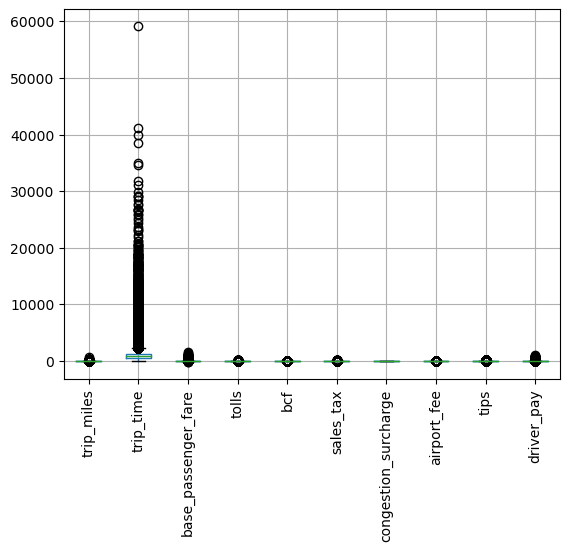

In [138]:
# do we still need to find and filter outliers for this project? suppose all the data collected well
# trip_data_outliers = fhvhv_tripdata_2021_01[['trip_miles','trip_time','base_passenger_fare','tolls','bcf',
#                        'sales_tax','congestion_surcharge','airport_fee','tips','driver_pay']].boxplot(rot=90)

# trip_data_outliers
Image.open("img/trip_data_outliers.png")

In [139]:
# trip_data_outliers.figure.savefig("img/trip_data_outliers.png",bbox_inches="tight")

No abnormal extreme values detected except for `trip_time`. However, the trip can take very long time in reality. No operation applied here.

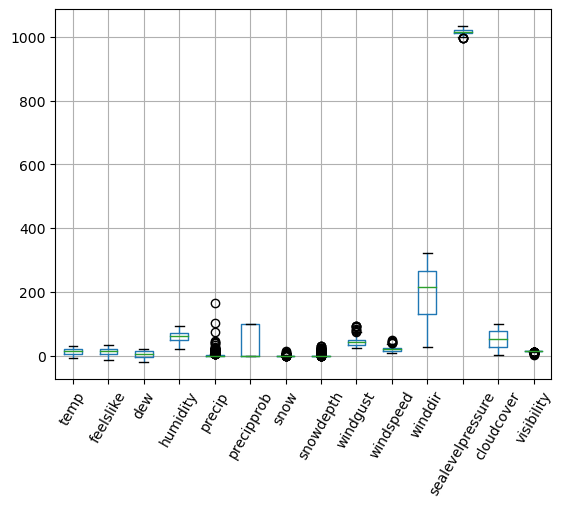

In [140]:
# weather_attrs = ['temp','feelslike','dew','humidity','precip','precipprob','snow','snowdepth','windgust','windspeed','winddir','sealevelpressure','cloudcover','visibility']
# weather_data_outliers = nyc_weather_2021[weather_attrs].boxplot(rot=60)
# weather_data_outliers
Image.open("img/weather_data_outliers.png")

In [141]:
# weather_data_outliers.figure.savefig("img/weather_data_outliers.png",bbox_inches="tight")

No abnormal extreme values detected except for `precip`. Also, we will `windgust` with our prediction and there could be further improvement.

In [142]:
# save the processed data for further purposes
fhvhv_tripdata_2021_01.to_parquet('clean_data/tripdata_2021_01.parquet',index=False)
nyc_weather_2021.to_csv('clean_data/weatherdata_2021.csv',index=False)
taxi_zones.to_file('clean_data/taxi_zones_2021.shp',index=False)
taxi_zone_lookup.to_csv('clean_data/taxi_zone_lookup_2021.csv',index=False)

## Exploratory Data Analysis (EDA)

In [95]:
# load clean data for convenience
fhvhv_tripdata_2021_01 = pq.read_table('clean_data/tripdata_2021_01.parquet').to_pandas()
nyc_weather_2021 = pd.read_csv('clean_data/weatherdata_2021.csv')
taxi_zones = gpd.read_file('clean_data/taxi_zones_2021.shp')
taxi_zone_lookup = pd.read_csv('clean_data/taxi_zone_lookup_2021.csv')

The first thing we want to investigate is, where do the most trip occured? Looking at the pickup and drop-off locations of the taxi trips, we can see that       
the distribution of those locations are quiet similar, so is there really a region where most of the trip occured in NYC? What are they? When do the customers go there?

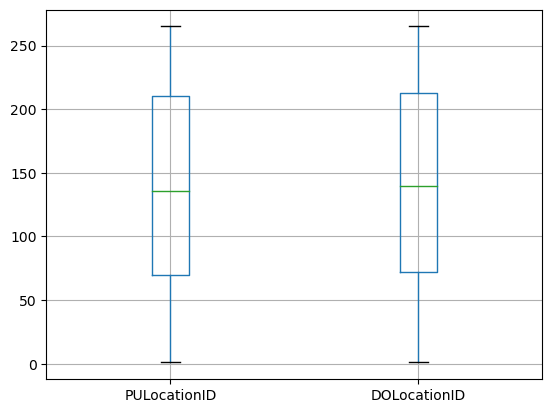

In [96]:
# trip_locations = fhvhv_tripdata_2021_01[['PULocationID','DOLocationID']].boxplot()
# trip_locations.figure.savefig("img/trip_loc_distribution.png",bbox_inches="tight")
# trip_locations
Image.open("img/trip_loc_distribution.png")

In [97]:
## warning: takes about 20 secs
# Filter the data according to our need
# All pickup (originate) locations in Jan,2021
# All drop-off (destination) locations in Jan,2021
# now seperate the data based on day (6:00-18:00) and night (18:00-6:00)
day_start = time(6,0,0)
day_end = time(18,0,0)
# locations in day time
tripdata_2021_01_src_day = fhvhv_tripdata_2021_01.loc[(fhvhv_tripdata_2021_01['pickup_datetime'].dt.time >= day_start) & (fhvhv_tripdata_2021_01['pickup_datetime'].dt.time <= day_end)]
tripdata_2021_01_dst_day = fhvhv_tripdata_2021_01.loc[(fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time >= day_start) & (fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time <= day_end)]
# locations in night
tripdata_2021_01_src_night = fhvhv_tripdata_2021_01.loc[(fhvhv_tripdata_2021_01['pickup_datetime'].dt.time < day_start) | (fhvhv_tripdata_2021_01['pickup_datetime'].dt.time > day_end)]
tripdata_2021_01_dst_night = fhvhv_tripdata_2021_01.loc[(fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time < day_start) | (fhvhv_tripdata_2021_01['dropoff_datetime'].dt.time > day_end)]

### Geospatial Analysis

['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough', 'geometry']


<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

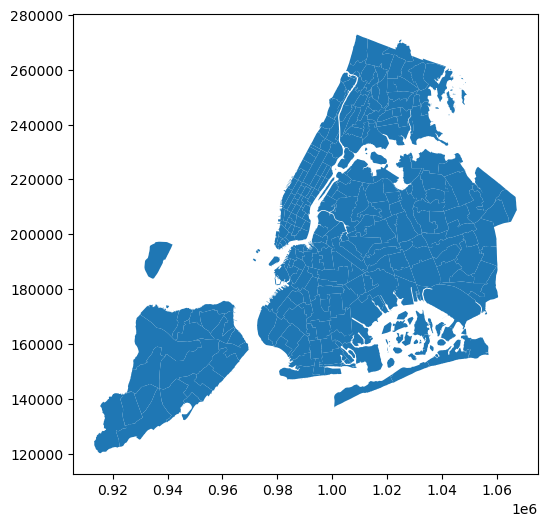

In [98]:
taxi_zones.plot(figsize=(6,6))
print(taxi_zones.columns.to_list())
taxi_zones.crs

In [99]:
taxi_zones = taxi_zones.to_crs(2263)
taxi_zones['centroid'] = taxi_zones.centroid

In [100]:
taxi_zones = taxi_zones.to_crs(epsg=4326) # project the centroids' locations to another coordinate system
taxi_zones['centroid'] = taxi_zones['centroid'].to_crs(epsg=4326)
taxi_zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  \
0            EWR  POLYGON ((-74.18445 40.69500, -74.18449 40.695...   
1         Queens  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...   
2          Bronx  POLYGON ((-73.84793 40.87134, -73.84725 40.870...   
3      Manhattan  POLYGON ((-73.97177 40.72582, -73.97179 40.725...   
4  Staten Island  POLYGON ((-74.17422 40.56257, -74.17349 40.562...   

                     centroid  
0  POINT (-74.17400 40.69183)  
1  POINT (-73.83130 40.61675)  
2  POINT (-73.84742 40.86447)  
3  POINT (-73.97697 40.72375)  
4  POINT (-74.18849 40.55266)

In [101]:
m1 = folium.Map(location=[40.70, -73.94], zoom_start=12,tiles="Stamen Toner")

# add centroid marker to each taxi zones
latitudes = []
longitudes = []
# markers_group = folium.FeatureGroup(name='Taxi Zones Centroids')
for _, r in taxi_zones.iterrows():
    lat = r['centroid'].y
    latitudes.append(lat)
    lon = r['centroid'].x
    longitudes.append(lon)
    folium.Marker(location=[lat, lon], popup='LocationID:{}<br>Zone:{}<br>Borough:{}'.format(r['LocationID'], r['zone'], r['borough']),icon=folium.Icon(icon='info-sign')).add_to(m1)

# project geometries on the map to locate precise regions of taxi zones
for _, r in taxi_zones.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.0001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,style_function=lambda x: {'fillColor': 'green'})
    folium.Popup(r['zone']).add_to(geo_j)
    geo_j.add_to(m1)
    
# markers_group.add_to(m)
taxi_zones['c_latitude'] = latitudes
taxi_zones['c_longitude'] = longitudes
m1.save('maps/taxi_zones.html')
m1

In the following sections we will use this as an reference map.

#### Pickup locations heatmap in Jan,2021

In [102]:
pickup_loc_2021_1 = fhvhv_tripdata_2021_01[['PULocationID']].value_counts()
pickup_loc_2021_1 = pd.DataFrame(pickup_loc_2021_1)
pickup_loc_2021_1.columns = ['count']
pickup_loc_2021_1 = pickup_loc_2021_1.merge(taxi_zones,left_on='PULocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
pickup_loc_2021_1.drop(columns=['LocationID'],inplace=True)

In [103]:
m2 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

pickup_loc_2021_1_group = folium.FeatureGroup(name='Jan Pickup Locations')
HeatMap(pickup_loc_2021_1,min_opacity=0.4,blur=18).add_to(pickup_loc_2021_1_group).add_to(m2)
folium.LayerControl().add_to(m2)
m2.save('maps/pickup_2021_1.html')
m2

Most of the pickup locations appears around North-East (near the coast line to Jersey city on the continent) and central part of the NYC, which are Manhattan and Brooklyn. Also we see there's a indentical pickup hotspot where located among Atlantic Avenue and Eastern Parkway with location ID 61. Take a look at this location, we found it is Brooklyn, Crown Heights North.

#### Drop-off locations heatmap in Jan,2021

In [104]:
dropoff_loc_2021_1 = fhvhv_tripdata_2021_01[['DOLocationID']].value_counts()
dropoff_loc_2021_1 = pd.DataFrame(dropoff_loc_2021_1)
dropoff_loc_2021_1.columns = ['count']
dropoff_loc_2021_1 = dropoff_loc_2021_1.merge(taxi_zones,left_on='DOLocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
dropoff_loc_2021_1.drop(columns=['LocationID'],inplace=True)

In [105]:
m3 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

dropoff_loc_2021_1_group = folium.FeatureGroup(name='Jan Drop-off Locations')
HeatMap(dropoff_loc_2021_1,min_opacity=0.4,blur=18).add_to(dropoff_loc_2021_1_group).add_to(m3)
folium.LayerControl().add_to(m3)
m3.save('maps/dropoff_2021_1.html')
m3

#### Pickup locations (day&night) heatmap in Jan,2021

In [106]:
pickup_loc_2021_1_day = tripdata_2021_01_src_day[['PULocationID']].value_counts()
pickup_loc_2021_1_day = pd.DataFrame(pickup_loc_2021_1_day)
pickup_loc_2021_1_day.columns = ['count']
pickup_loc_2021_1_day = pickup_loc_2021_1_day.merge(taxi_zones,left_on='PULocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
pickup_loc_2021_1_day.drop(columns=['LocationID'],inplace=True)

In [107]:
m4 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

pickup_loc_2021_1_day_group = folium.FeatureGroup(name='Jan Pickup Locations (day)')
HeatMap(pickup_loc_2021_1_day,min_opacity=0.4,blur=18).add_to(pickup_loc_2021_1_day_group).add_to(m4)
folium.LayerControl().add_to(m4)
m4.save('maps/pickup_2021_1_day.html')
m4

In [108]:
pickup_loc_2021_1_nt = tripdata_2021_01_src_night[['PULocationID']].value_counts()
pickup_loc_2021_1_nt = pd.DataFrame(pickup_loc_2021_1_nt)
pickup_loc_2021_1_nt.columns = ['count']
pickup_loc_2021_1_nt = pickup_loc_2021_1_nt.merge(taxi_zones,left_on='PULocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
pickup_loc_2021_1_nt.drop(columns=['LocationID'],inplace=True)

In [109]:
m5 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

pickup_loc_2021_1_nt_group = folium.FeatureGroup(name='Jan Pickup Locations(night)')
HeatMap(pickup_loc_2021_1_nt,min_opacity=0.4,blur=18).add_to(pickup_loc_2021_1_nt_group).add_to(m5)
folium.LayerControl().add_to(m5)
m5.save('maps/pickup_2021_1_night.html')
m5

#### Drop-off locations (day&night) heatmap in Jan,2021

In [110]:
dropoff_loc_2021_1_day = tripdata_2021_01_dst_day[['DOLocationID']].value_counts()
dropoff_loc_2021_1_day = pd.DataFrame(dropoff_loc_2021_1_day)
dropoff_loc_2021_1_day.columns = ['count']
dropoff_loc_2021_1_day = dropoff_loc_2021_1_day.merge(taxi_zones,left_on='DOLocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
dropoff_loc_2021_1_day.drop(columns=['LocationID'],inplace=True)

In [111]:
m6 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

dropoff_loc_2021_1_day_group = folium.FeatureGroup(name='Jan Drop-off Locations(day)')
HeatMap(dropoff_loc_2021_1_day,min_opacity=0.4,blur=18).add_to(dropoff_loc_2021_1_day_group).add_to(m6)
folium.LayerControl().add_to(m6)
m6.save('maps/dropoff_2021_1_day.html')
m6

In [112]:
dropoff_loc_2021_1_nt = tripdata_2021_01_dst_night[['DOLocationID']].value_counts()
dropoff_loc_2021_1_nt = pd.DataFrame(dropoff_loc_2021_1_nt)
dropoff_loc_2021_1_nt.columns = ['count']
dropoff_loc_2021_1_nt = dropoff_loc_2021_1_nt.merge(taxi_zones,left_on='DOLocationID',right_on='LocationID')[['LocationID','c_latitude','c_longitude','count']]
dropoff_loc_2021_1_nt.drop(columns=['LocationID'],inplace=True)

In [113]:
m7 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

dropoff_loc_2021_1_nt_group = folium.FeatureGroup(name='Jan Drop-off Locations(night)')
HeatMap(dropoff_loc_2021_1_day,min_opacity=0.4,blur=18).add_to(dropoff_loc_2021_1_day_group).add_to(m7)
folium.LayerControl().add_to(m7)
m7.save('maps/dropoff_2021_1_night.html')
m7

#### Trip route analysis

In [114]:
start_locs = fhvhv_tripdata_2021_01[['PULocationID']].merge(taxi_zones,left_on='PULocationID',right_on='LocationID')[['c_latitude','c_longitude']]
start_locs.rename(columns={'c_latitude':'src_lat','c_longitude':'src_lon'},inplace=True)

end_locs = fhvhv_tripdata_2021_01[['DOLocationID']].merge(taxi_zones,left_on='DOLocationID',right_on='LocationID')[['c_latitude','c_longitude']]
end_locs.rename(columns={'c_latitude':'dst_lat','c_longitude':'dst_lon'},inplace=True)

route_data_2021_01 = pd.concat([start_locs,end_locs],axis=1)
route_data_2021_01.dropna(inplace=True)

In [115]:
route_data_2021_01 = route_data_2021_01.value_counts().index.to_frame(index=False)

In [116]:
# m8 = folium.Map(location=[40.70, -73.94], zoom_start=12, tiles="Stamen Toner")

src_lats = route_data_2021_01['src_lat'].to_list()
src_lons = route_data_2021_01['src_lon'].to_list()
dst_lats = route_data_2021_01['dst_lat'].to_list()
dst_lons = route_data_2021_01['dst_lon'].to_list()

poly_ls_top10 = folium.PolyLine(locations=[[*zip(src_lats,src_lons)][:10],[*zip(dst_lats,dst_lons)][:10]],color='green')
poly_ls_top10.add_to(m1)

m1

In [117]:
poly_ls_bottom10 = folium.PolyLine(locations=[[*zip(src_lats,src_lons)][-10:],[*zip(dst_lats,dst_lons)][-10:]],color='red')
poly_ls_bottom10.add_to(m1)

m1

### Split Train/Test Datasets

Now in this section we will integrate trip data from 2021-01 with the weather data to perform the regression analysis. The geospatial analysis above has shown some interesting features but still we want to be able to precisely predict the peak of the order flow (unit: day) so that taxi drivers can re-arrange the time schedule to aquire sufficient orders on specific time instead of wandering around the NYC along the day.

In [118]:
fhvhv_tripdata_2021_01['pickup_datetime'] = fhvhv_tripdata_2021_01['pickup_datetime'].dt.to_period('D') # extract the datetime of the orders
fhvhv_tripdata_2021_01['pickup_datetime'] = pd.to_datetime(fhvhv_tripdata_2021_01['pickup_datetime'].astype(str))
fhvhv_tripdata_2021_01['pickup_datetime'].value_counts().sort_index()

2021-01-01    291955
2021-01-02    233727
2021-01-03    208926
2021-01-04    236170
2021-01-05    248482
2021-01-06    262438
2021-01-07    270854
2021-01-08    308039
2021-01-09    313316
2021-01-10    254453
2021-01-11    253990
2021-01-12    266300
2021-01-13    272475
2021-01-14    280743
2021-01-15    328935
2021-01-16    308360
2021-01-17    268446
2021-01-18    237573
2021-01-19    250860
2021-01-20    274662
2021-01-21    283273
2021-01-22    320679
2021-01-23    333216
2021-01-24    274221
2021-01-25    260786
2021-01-26    276403
2021-01-27    284233
2021-01-28    306725
2021-01-29    365895
2021-01-30    340794
2021-01-31    285434
Name: pickup_datetime, dtype: int64

In [119]:
fhvhv_tripdata_2021_01.head()

hvfhs_license_num dispatching_base_num originating_base_num  \
0            HV0003               B02682               B02682   
1            HV0003               B02682               B02682   
2            HV0003               B02764               B02764   
3            HV0003               B02764               B02764   
4            HV0003               B02764               B02764   

     request_datetime   on_scene_datetime pickup_datetime    dropoff_datetime  \
0 2021-01-01 00:28:09 2021-01-01 00:31:42      2021-01-01 2021-01-01 00:49:07   
1 2021-01-01 00:45:56 2021-01-01 00:55:19      2021-01-01 2021-01-01 01:18:21   
2 2021-01-01 00:21:15 2021-01-01 00:22:41      2021-01-01 2021-01-01 00:38:05   
3 2021-01-01 00:39:12 2021-01-01 00:42:37      2021-01-01 2021-01-01 00:45:50   
4 2021-01-01 00:46:11 2021-01-01 00:47:17      2021-01-01 2021-01-01 01:08:42   

   PULocationID  DOLocationID  trip_miles  ...  sales_tax  \
0           230           166        5.26  ...       1.98   
1           152           167        3.65  ...       1.63   
2           233           142        3.51  ...       1.25   
3           142           143        0.74  ...       0.70   
4           143            78        9.20  ...       2.41   

   congestion_surcharge  airport_fee  tips  driver_pay  shared_request_flag  \
0                  2.75          0.0  0.00       14.99                    0   
1                  0.00          0.0  0.00       17.06                    0   
2                  2.75          0.0  0.94       12.98                    0   
3                  2.75          0.0  0.00        7.41                    0   
4                  2.75          0.0  0.00       22.44                    0   

   shared_match_flag  access_a_ride_flag  wav_request_flag  wav_match_flag  
0                  0                   0                 0               0  
1                  0                   0                 0               0  
2                  0                   0                 0               0  
3                  0                   0                 0               0  
4                  0                   0                 0               0  

[5 rows x 24 columns]

In [120]:
fhvhv_tripdata_2021_01.columns.to_list()
drop_cols_trip = ['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'dropoff_datetime',
 'DOLocationID',
 'shared_request_flag',
 'access_a_ride_flag']
fhvhv_tripdata_2021_01.drop(columns=drop_cols_trip,inplace=True)
fhvhv_tripdata_2021_01.head()

pickup_datetime  PULocationID  trip_miles  trip_time  base_passenger_fare  \
0      2021-01-01           230        5.26        923                22.28   
1      2021-01-01           152        3.65       1382                18.36   
2      2021-01-01           233        3.51        849                14.05   
3      2021-01-01           142        0.74        179                 7.91   
4      2021-01-01           143        9.20       1228                27.11   

   tolls   bcf  sales_tax  congestion_surcharge  airport_fee  tips  \
0    0.0  0.67       1.98                  2.75          0.0  0.00   
1    0.0  0.55       1.63                  0.00          0.0  0.00   
2    0.0  0.48       1.25                  2.75          0.0  0.94   
3    0.0  0.24       0.70                  2.75          0.0  0.00   
4    0.0  0.81       2.41                  2.75          0.0  0.00   

   driver_pay  shared_match_flag  wav_request_flag  wav_match_flag  
0       14.99                  0                 0               0  
1       17.06                  0                 0               0  
2       12.98                  0                 0               0  
3        7.41                  0                 0               0  
4       22.44                  0                 0               0

In [121]:
# nyc_weather_2021.columns.to_list()
drop_cols_weather = ['name','address','resolvedAddress']
weather_data_1 = nyc_weather_2021[nyc_weather_2021.datetime.str.contains("2021-01") | nyc_weather_2021.datetime.str.contains("2021-02-01")] # select weather data for Jan,2021
weather_data_1['preciptype'] = weather_data_1.preciptype.map({'rain':0,'rain,snow':1,'snow':2}) # here we assign definite info to numeric flags
# weather_data_1.loc[weather_data_1['preciptype']=='rain'] = 0
# weather_data_1.loc[weather_data_1['preciptype']=='rain,snow'] = 1
# weather_data_1.loc[weather_data_1['preciptype']=='snow'] = 2
# pd.get_dummies(nyc_weather_2021['preciptype'])
weather_data_1.drop(columns=drop_cols_weather,inplace=True)
weather_data_1.head()

/var/folders/7h/m14q6_7934g5kkp_8sh_875m0000gn/T/ipykernel_82205/905672435.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_1['preciptype'] = weather_data_1.preciptype.map({'rain':0,'rain,snow':1,'snow':2}) # here we assign definite info to numeric flags
/var/folders/7h/m14q6_7934g5kkp_8sh_875m0000gn/T/ipykernel_82205/905672435.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_1.drop(columns=drop_cols_weather,inplace=True)


datetime  temp  feelslike  dew  humidity  precip  precipprob  preciptype  \
0  2021-01-01   2.5       -0.2 -3.0      67.8   15.33         100           0   
1  2021-01-02   5.8        3.6  1.2      74.0    2.38         100           0   
2  2021-01-03   2.5       -1.6 -0.5      80.7    5.09         100           1   
3  2021-01-04   3.6        1.1 -0.2      76.6    0.84         100           1   
4  2021-01-05   3.8        1.3 -1.5      68.7    0.00           0           0   

   snow  snowdepth  windgust  windspeed  winddir  sealevelpressure  \
0   0.0        0.0     54.60       15.5     69.8            1028.9   
1   1.9        0.6     54.60       25.5    246.9            1012.4   
2   1.2        1.7     42.20       24.1     66.4            1017.0   
3   0.5        0.7     36.95       17.3    141.1            1014.6   
4   0.0        0.1     31.70       15.2    124.4            1013.1   

   cloudcover  visibility  uvindex  
0        50.6        14.0        3  
1        63.9        12.2        5  
2        81.5        13.2        1  
3        89.3        15.6        4  
4        98.8        16.0        2

In [122]:
weather_data_1['datetime'] = pd.to_datetime(weather_data_1['datetime'])

/var/folders/7h/m14q6_7934g5kkp_8sh_875m0000gn/T/ipykernel_82205/1044598032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_1['datetime'] = pd.to_datetime(weather_data_1['datetime'])


In [123]:
trip_data_1 = fhvhv_tripdata_2021_01.merge(weather_data_1,left_on="pickup_datetime",right_on="datetime")
trip_data_1.drop(columns=["datetime"],inplace=True)
trip_data_1.head()

pickup_datetime  PULocationID  trip_miles  trip_time  base_passenger_fare  \
0      2021-01-01           230        5.26        923                22.28   
1      2021-01-01           152        3.65       1382                18.36   
2      2021-01-01           233        3.51        849                14.05   
3      2021-01-01           142        0.74        179                 7.91   
4      2021-01-01           143        9.20       1228                27.11   

   tolls   bcf  sales_tax  congestion_surcharge  airport_fee  ...  preciptype  \
0    0.0  0.67       1.98                  2.75          0.0  ...           0   
1    0.0  0.55       1.63                  0.00          0.0  ...           0   
2    0.0  0.48       1.25                  2.75          0.0  ...           0   
3    0.0  0.24       0.70                  2.75          0.0  ...           0   
4    0.0  0.81       2.41                  2.75          0.0  ...           0   

   snow  snowdepth  windgust  windspeed  winddir  sealevelpressure  \
0   0.0        0.0      54.6       15.5     69.8            1028.9   
1   0.0        0.0      54.6       15.5     69.8            1028.9   
2   0.0        0.0      54.6       15.5     69.8            1028.9   
3   0.0        0.0      54.6       15.5     69.8            1028.9   
4   0.0        0.0      54.6       15.5     69.8            1028.9   

   cloudcover  visibility  uvindex  
0        50.6        14.0        3  
1        50.6        14.0        3  
2        50.6        14.0        3  
3        50.6        14.0        3  
4        50.6        14.0        3  

[5 rows x 31 columns]

In [124]:
trip_dataset = trip_data_1.groupby(['pickup_datetime','PULocationID']).mean()
trip_dataset

trip_miles    trip_time  base_passenger_fare  \
pickup_datetime PULocationID                                                 
2021-01-01      2              11.020000  2407.000000            46.440000   
                3               4.701788   804.755000            17.680563   
                4               5.321923   968.721573            20.029288   
                5               6.539510   923.813725            20.157843   
                6               5.276387   793.503226            20.149161   
...                                  ...          ...                  ...   
2021-01-31      260             4.211518   802.254792            14.678714   
                261             5.721994  1074.535112            22.522416   
                262             4.827382   881.809793            17.335621   
                263             4.504064   871.659754            16.812508   
                265             6.150526   918.421053            18.214737   

                                 tolls       bcf  sales_tax  \
pickup_datetime PULocationID                                  
2021-01-01      2             0.000000  1.390000   4.120000   
                3             0.429762  0.548975   1.558388   
                4             0.661456  0.667460   1.751477   
                5             1.910098  0.699118   1.740784   
                6             1.589935  0.673097   1.877548   
...                                ...       ...        ...   
2021-01-31      260           0.690104  0.451973   1.265016   
                261           1.653329  0.715899   1.828357   
                262           0.959162  0.546714   1.496883   
                263           0.859916  0.526235   1.428425   
                265           1.522105  0.588421   1.364737   

                              congestion_surcharge  airport_fee      tips  \
pickup_datetime PULocationID                                                
2021-01-01      2                         0.000000     0.000000  0.000000   
                3                         0.051562     0.025000  0.165587   
                4                         2.694474     0.021254  0.587673   
                5                         0.026961     0.000000  1.014804   
                6                         0.141935     0.000000  0.591032   
...                                            ...          ...       ...   
2021-01-31      260                       0.239417     0.033946  0.400567   
                261                       2.614817     0.112360  0.885014   
                262                       2.695621     0.070621  0.633154   
                263                       2.664452     0.055087  0.567310   
                265                       0.000000     0.131579  0.421053   

                              driver_pay  ...  preciptype  snow  snowdepth  \
pickup_datetime PULocationID              ...                                
2021-01-01      2              32.580000  ...         0.0   0.0        0.0   
                3              14.309350  ...         0.0   0.0        0.0   
                4              16.566589  ...         0.0   0.0        0.0   
                5              17.982941  ...         0.0   0.0        0.0   
                6              16.969419  ...         0.0   0.0        0.0   
...                                  ...  ...         ...   ...        ...   
2021-01-31      260            12.168219  ...         2.0  10.0        4.3   
                261            17.374143  ...         2.0  10.0        4.3   
                262            13.884482  ...         2.0  10.0        4.3   
                263            13.437667  ...         2.0  10.0        4.3   
                265            15.193684  ...         2.0  10.0        4.3   

                              windgust  windspeed  winddir  sealevelpressure  \
pickup_datetime PULocationID                                                   
2021-01-01      2 

In [125]:
# Now we see that for some flags (boolean and categorical data) we need mode instead of mean
trip_dataset['preciptype'] = trip_data_1.groupby(['pickup_datetime','PULocationID'])['preciptype'].agg(pd.Series.mode)
trip_dataset['shared_match_flag'] = trip_data_1.groupby(['pickup_datetime','PULocationID'])['shared_match_flag'].agg(pd.Series.mode)
trip_dataset['wav_request_flag'] = trip_data_1.groupby(['pickup_datetime','PULocationID'])['wav_request_flag'].agg(pd.Series.mode)
trip_dataset['wav_match_flag'] = trip_data_1.groupby(['pickup_datetime','PULocationID'])['wav_match_flag'].agg(pd.Series.mode)
trip_dataset

trip_miles    trip_time  base_passenger_fare  \
pickup_datetime PULocationID                                                 
2021-01-01      2              11.020000  2407.000000            46.440000   
                3               4.701788   804.755000            17.680563   
                4               5.321923   968.721573            20.029288   
                5               6.539510   923.813725            20.157843   
                6               5.276387   793.503226            20.149161   
...                                  ...          ...                  ...   
2021-01-31      260             4.211518   802.254792            14.678714   
                261             5.721994  1074.535112            22.522416   
                262             4.827382   881.809793            17.335621   
                263             4.504064   871.659754            16.812508   
                265             6.150526   918.421053            18.214737   

                                 tolls       bcf  sales_tax  \
pickup_datetime PULocationID                                  
2021-01-01      2             0.000000  1.390000   4.120000   
                3             0.429762  0.548975   1.558388   
                4             0.661456  0.667460   1.751477   
                5             1.910098  0.699118   1.740784   
                6             1.589935  0.673097   1.877548   
...                                ...       ...        ...   
2021-01-31      260           0.690104  0.451973   1.265016   
                261           1.653329  0.715899   1.828357   
                262           0.959162  0.546714   1.496883   
                263           0.859916  0.526235   1.428425   
                265           1.522105  0.588421   1.364737   

                              congestion_surcharge  airport_fee      tips  \
pickup_datetime PULocationID                                                
2021-01-01      2                         0.000000     0.000000  0.000000   
                3                         0.051562     0.025000  0.165587   
                4                         2.694474     0.021254  0.587673   
                5                         0.026961     0.000000  1.014804   
                6                         0.141935     0.000000  0.591032   
...                                            ...          ...       ...   
2021-01-31      260                       0.239417     0.033946  0.400567   
                261                       2.614817     0.112360  0.885014   
                262                       2.695621     0.070621  0.633154   
                263                       2.664452     0.055087  0.567310   
                265                       0.000000     0.131579  0.421053   

                              driver_pay  ...  preciptype  snow  snowdepth  \
pickup_datetime PULocationID              ...                                
2021-01-01      2              32.580000  ...           0   0.0        0.0   
                3              14.309350  ...           0   0.0        0.0   
                4              16.566589  ...           0   0.0        0.0   
                5              17.982941  ...           0   0.0        0.0   
                6              16.969419  ...           0   0.0        0.0   
...                                  ...  ...         ...   ...        ...   
2021-01-31      260            12.168219  ...           2  10.0        4.3   
                261            17.374143  ...           2  10.0        4.3   
                262            13.884482  ...           2  10.0        4.3   
                263            13.437667  ...           2  10.0        4.3   
                265            15.193684  ...           2  10.0        4.3   

                              windgust  windspeed  winddir  sealevelpressure  \
pickup_datetime PULocationID                                                   
2021-01-01      2 

In [126]:
trip_dataset['order_count'] = trip_data_1.groupby(['pickup_datetime','PULocationID']).agg({'PULocationID':'count'}).rename(columns={'PULocationID':'order_count'})['order_count']
trip_dataset

trip_miles    trip_time  base_passenger_fare  \
pickup_datetime PULocationID                                                 
2021-01-01      2              11.020000  2407.000000            46.440000   
                3               4.701788   804.755000            17.680563   
                4               5.321923   968.721573            20.029288   
                5               6.539510   923.813725            20.157843   
                6               5.276387   793.503226            20.149161   
...                                  ...          ...                  ...   
2021-01-31      260             4.211518   802.254792            14.678714   
                261             5.721994  1074.535112            22.522416   
                262             4.827382   881.809793            17.335621   
                263             4.504064   871.659754            16.812508   
                265             6.150526   918.421053            18.214737   

                                 tolls       bcf  sales_tax  \
pickup_datetime PULocationID                                  
2021-01-01      2             0.000000  1.390000   4.120000   
                3             0.429762  0.548975   1.558388   
                4             0.661456  0.667460   1.751477   
                5             1.910098  0.699118   1.740784   
                6             1.589935  0.673097   1.877548   
...                                ...       ...        ...   
2021-01-31      260           0.690104  0.451973   1.265016   
                261           1.653329  0.715899   1.828357   
                262           0.959162  0.546714   1.496883   
                263           0.859916  0.526235   1.428425   
                265           1.522105  0.588421   1.364737   

                              congestion_surcharge  airport_fee      tips  \
pickup_datetime PULocationID                                                
2021-01-01      2                         0.000000     0.000000  0.000000   
                3                         0.051562     0.025000  0.165587   
                4                         2.694474     0.021254  0.587673   
                5                         0.026961     0.000000  1.014804   
                6                         0.141935     0.000000  0.591032   
...                                            ...          ...       ...   
2021-01-31      260                       0.239417     0.033946  0.400567   
                261                       2.614817     0.112360  0.885014   
                262                       2.695621     0.070621  0.633154   
                263                       2.664452     0.055087  0.567310   
                265                       0.000000     0.131579  0.421053   

                              driver_pay  ...  snow  snowdepth  windgust  \
pickup_datetime PULocationID              ...                              
2021-01-01      2              32.580000  ...   0.0        0.0      54.6   
                3              14.309350  ...   0.0        0.0      54.6   
                4              16.566589  ...   0.0        0.0      54.6   
                5              17.982941  ...   0.0        0.0      54.6   
                6              16.969419  ...   0.0        0.0      54.6   
...                                  ...  ...   ...        ...       ...   
2021-01-31      260            12.168219  ...  10.0        4.3      38.9   
                261            17.374143  ...  10.0        4.3      38.9   
                262            13.884482  ...  10.0        4.3      38.9   
                263            13.437667  ...  10.0        4.3      38.9   
                265            15.193684  ...  10.0        4.3      38.9   

                              windspeed  winddir  sealevelpressure  \
pickup_datetime PULocationID                                         
2021-01-01      2                  15.5     69.8            1028

In [127]:
trip_dataset.drop(columns = ['shared_match_flag','wav_match_flag','wav_request_flag'],inplace=True) 
# here we see in integrated data these flags are all 0s, drop them directly

In [128]:
# trip_dataset.index.get_level_values('pickup_datetime').to_list()

In [129]:
trip_dataset.iloc[trip_dataset.index.get_level_values('pickup_datetime')=='2021-01-01'] # select daily data

trip_miles    trip_time  base_passenger_fare  \
pickup_datetime PULocationID                                                 
2021-01-01      2              11.020000  2407.000000            46.440000   
                3               4.701788   804.755000            17.680563   
                4               5.321923   968.721573            20.029288   
                5               6.539510   923.813725            20.157843   
                6               5.276387   793.503226            20.149161   
...                                  ...          ...                  ...   
                260             4.253714   767.176427            15.788814   
                261             6.041311  1041.014245            23.500385   
                262             5.039837   844.305006            19.179604   
                263             5.218826   866.887195            19.676082   
                265             7.213571   923.285714            23.022857   

                                 tolls       bcf  sales_tax  \
pickup_datetime PULocationID                                  
2021-01-01      2             0.000000  1.390000   4.120000   
                3             0.429762  0.548975   1.558388   
                4             0.661456  0.667460   1.751477   
                5             1.910098  0.699118   1.740784   
                6             1.589935  0.673097   1.877548   
...                                ...       ...        ...   
                260           0.655923  0.512068   1.406738   
                261           1.324202  0.776567   1.980214   
                262           1.057183  0.654098   1.637637   
                263           1.158483  0.661524   1.633864   
                265           0.437143  0.729286   1.899286   

                              congestion_surcharge  airport_fee      tips  \
pickup_datetime PULocationID                                                
2021-01-01      2                         0.000000     0.000000  0.000000   
                3                         0.051562     0.025000  0.165587   
                4                         2.694474     0.021254  0.587673   
                5                         0.026961     0.000000  1.014804   
                6                         0.141935     0.000000  0.591032   
...                                            ...          ...       ...   
                260                       0.193662     0.024092  0.403417   
                261                       2.620726     0.138889  0.453305   
                262                       2.685972     0.055297  0.796065   
                263                       2.630526     0.045732  0.722325   
                265                       0.000000     0.178571  0.406429   

                              driver_pay  ...  snow  snowdepth  windgust  \
pickup_datetime PULocationID              ...                              
2021-01-01      2              32.580000  ...   0.0        0.0      54.6   
                3              14.309350  ...   0.0        0.0      54.6   
                4              16.566589  ...   0.0        0.0      54.6   
                5              17.982941  ...   0.0        0.0      54.6   
                6              16.969419  ...   0.0        0.0      54.6   
...                                  ...  ...   ...        ...       ...   
                260            13.001586  ...   0.0        0.0      54.6   
                261            18.400370  ...   0.0        0.0      54.6   
                262            15.008475  ...   0.0        0.0      54.6   
                263            15.365335  ...   0.0        0.0      54.6   
                265            19.190714  ...   0.0        0.0      54.6   

                              windspeed  winddir  sealevelpressure  \
pickup_datetime PULocationID                                         
2021-01-01      2                  15.5     69.8            1028

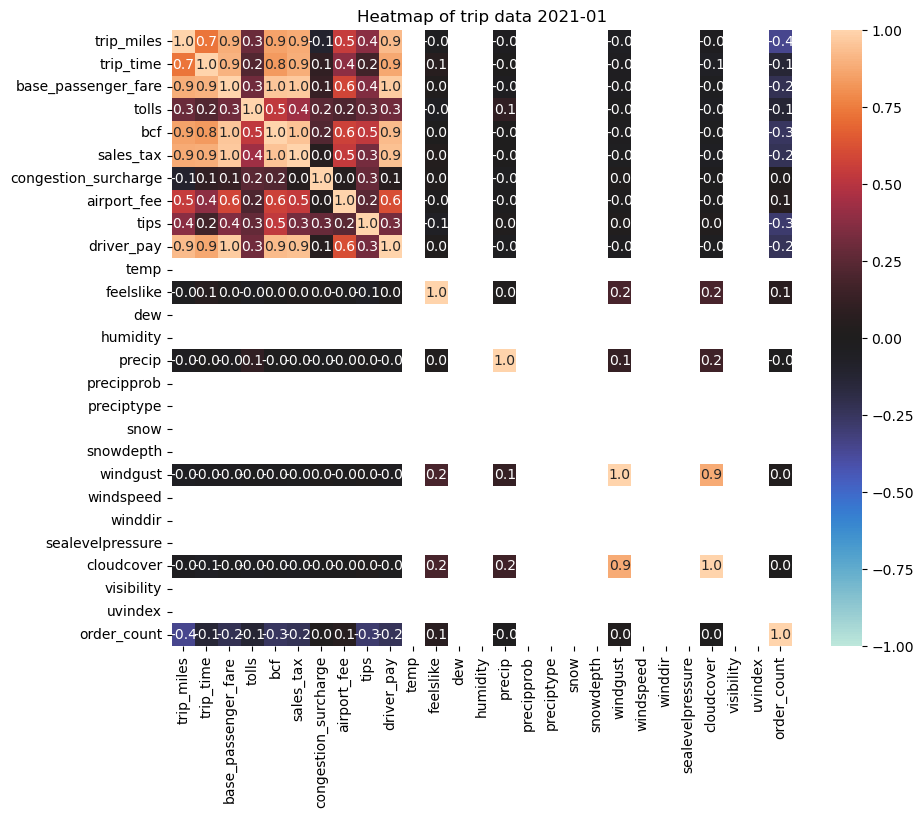

In [130]:
plt.figure(figsize=(10, 8))
sns.heatmap(day_1.corr(),cmap="icefire", norm=plt.Normalize(-1,1), annot=True, fmt='.1f')
plt.title("Heatmap of trip data 2021-01")
plt.show()

Here we apply a simple correlation analysis on features and the target label 'order_count', we hardly see any strong linear correlation among the target and any feature. Therefore, we first build a Lasso Regression Model to figure out what is most relevant features to the number of orders in each NYC area per day.

## Modeling

## Evaluation

## Deployment

### Build UI dashboard using ?

## Feedback

## References

## Acknowlegdement